In [2]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm
from datetime import datetime
plt.rcParams['text.usetex'] = True

# LOAD DATA

In [3]:
diffs = pd.read_csv('../data/diff_metrics.csv.gz')
diffs.head(2)

,id,v1,v2,BlockAddition,BlockEdit,BlockRelocation,BlockRemoval,RoleVariableAddition,RoleVariableEdit,RoleVariableRelocation,...,MetaEdit,PlatformAddition,PlatformRemoval,TaskAddition,TaskEdit,TaskRelocation,TaskRemoval,TaskFileAddition,TaskFileRelocation,TaskFileRemoval
0,030.ansible_bfg,1.0.0,1.0.1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,030.ansible_eksctl,1.0.0,1.0.1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [4]:
diffs.id.unique().size

8656

In [5]:
diffs.DependencyAddition.sum()

1272

# Preparation

In [6]:
diffs['v1'] = diffs['v1'].apply(lambda d: d.replace('v',''))
diffs['v2'] = diffs['v2'].apply(lambda d: d.replace('v',''))

In [7]:
len(diffs)

82756

In [8]:
RE_SEMVER = r'^(?:v|V)?(?P<v_major>\d+)\.(?P<v_minor>\d+)\.(?P<v_patch>\d+)(?P<v_misc>.*)$'
def comply_semver(series_of_releases):
    extracted = series_of_releases.str.extract(RE_SEMVER, expand=True)
    return (
        extracted
        [['v_major', 'v_minor', 'v_patch']]
        .astype('str')
        .assign(Semver=lambda d: d['v_major'] + '.' + d['v_minor'] + '.' + d['v_patch'])
        ['Semver']
    )

In [9]:
diffs['fromm'] = comply_semver(diffs['v1'])
diffs['tot'] = comply_semver(diffs['v2'])

In [10]:
def type_release(v2,fromm,tot):

    if v2 == "HEAD":
        return 'head'
    fromm=fromm.split('.')
    tot=tot.split('.')
    
    if fromm[-1] == 'nan' or tot[-1] == "nan":
        return 'notSemver'
    if fromm[0]!=tot[0]:
        return 'major'
    if fromm[1]!=tot[1]:
        return 'minor'
    if fromm[2]!=tot[2]:
        return 'patch'
    return 'pre'

diffs['release'] = diffs.apply(lambda d: type_release(d['v2'], d['fromm'], d['tot']), axis=1)

In [11]:
diffs.release.unique()

array(['patch', 'minor', 'major', 'pre'], dtype=object)

In [12]:
diffs = diffs.query('release != "notSemver" and release != "pre"')
diffs.fromm = diffs.fromm.replace({'nan.nan.nan':'first commit'})

In [13]:
df_melted = (pd.melt(diffs.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )

## Let's check the number of changes that happend for each release type

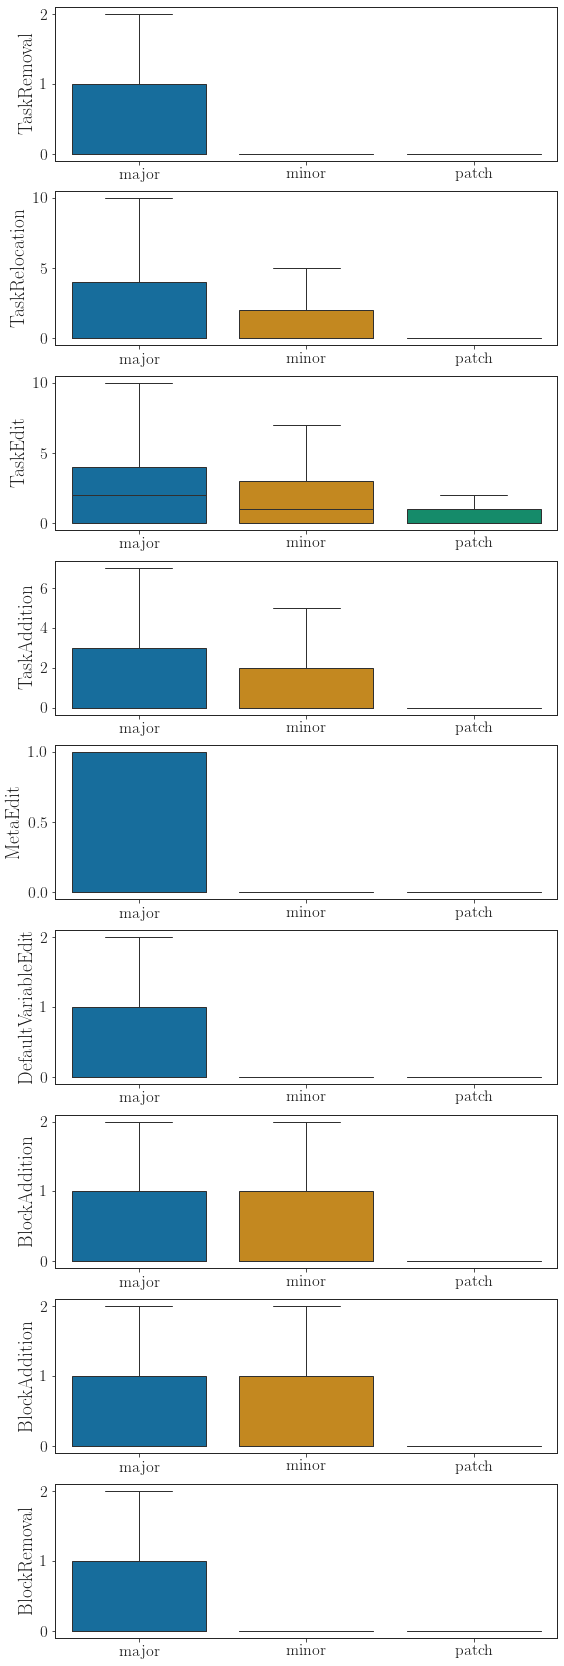

In [14]:
cols= diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
cols = ['TaskRemoval','TaskRelocation','TaskEdit','TaskAddition','MetaEdit','DefaultVariableEdit','BlockAddition','BlockAddition', 'BlockRemoval']
fig, axes = plt.subplots(len(cols), 1, sharex=False, sharey=False)
fig.set_size_inches(9,30)

for i, var in enumerate(cols):
    df_tmp = df_melted.query('variable =="'+var+'"')
    ax = sns.boxplot(x="release", 
                     y="value", 
                     order = ['major','minor','patch'],
                     data=df_tmp, 
                     ax=axes[i],
                     showfliers=False,
                     linewidth=1)
    ax.set_ylabel(var)
    ax.set_xlabel('')

(0.0, 10.0)

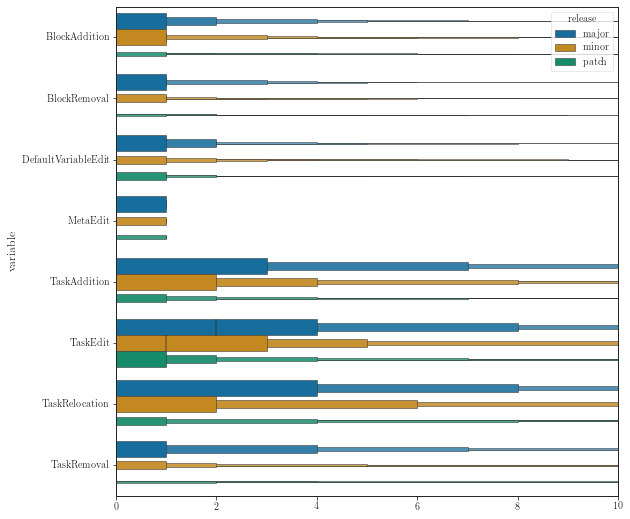

In [14]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
fig.set_size_inches(9,9)
cols = ['TaskRemoval','TaskRelocation','TaskEdit','TaskAddition','MetaEdit','DefaultVariableEdit','BlockAddition','BlockAddition', 'BlockRemoval']

df_melted2 = df_melted[df_melted.variable.isin(cols)]
ax = sns.boxenplot(x="value", 
                 y="variable", 
                 hue='release',
                 hue_order = ['major','minor','patch'],
                 data=df_melted2, 
                 linewidth=1)
ax.set_xlabel('')
ax.set_xlim(0,10)


In [15]:
diffs.columns

Index(['id', 'v1', 'v2', 'BlockAddition', 'BlockEdit', 'BlockRelocation',
       'BlockRemoval', 'RoleVariableAddition', 'RoleVariableEdit',
       'RoleVariableRelocation', 'RoleVariableRemoval', 'RoleVarFileAddition',
       'RoleVarFileRelocation', 'RoleVarFileRemoval',
       'DefaultVariableAddition', 'DefaultVariableEdit',
       'DefaultVariableRelocation', 'DefaultVariableRemoval',
       'DefaultVarFileAddition', 'DefaultVarFileRelocation',
       'DefaultVarFileRemoval', 'DependencyAddition', 'DependencyRemoval',
       'HandlerBlockAddition', 'HandlerBlockEdit', 'HandlerBlockRelocation',
       'HandlerBlockRemoval', 'HandlerTaskAddition', 'HandlerTaskEdit',
       'HandlerTaskRelocation', 'HandlerTaskRemoval', 'HandlerFileAddition',
       'HandlerFileRelocation', 'HandlerFileRemoval', 'MetaEdit',
       'PlatformAddition', 'PlatformRemoval', 'TaskAddition', 'TaskEdit',
       'TaskRelocation', 'TaskRemoval', 'TaskFileAddition',
       'TaskFileRelocation', 'TaskFileRemoval

## let's group variables 

In [16]:
diffs['Block'] = diffs['BlockAddition'] + diffs['BlockEdit']+ diffs['BlockRelocation'] + diffs['BlockRemoval']
diffs['RoleVariable'] = diffs['RoleVariableAddition'] + diffs['RoleVariableEdit']+ diffs['RoleVariableRelocation']+ diffs['RoleVariableRemoval']
diffs['RoleVariableFile'] = diffs['RoleVarFileAddition'] + diffs['RoleVarFileRelocation']+ diffs['RoleVarFileRemoval']
diffs['DefaultVariable'] = diffs['DefaultVariableAddition'] + diffs['DefaultVariableEdit']+ diffs['DefaultVariableRelocation'] + diffs['DefaultVariableRemoval']
diffs['DefaultVariableFile'] = diffs['DefaultVarFileAddition'] + diffs['DefaultVarFileRelocation']+ diffs['DefaultVarFileRemoval'] 
diffs['Dependency'] = diffs['DependencyAddition'] + diffs['DependencyRemoval']
diffs['HandlerBlock'] = diffs['HandlerBlockAddition'] + diffs['HandlerBlockEdit']+ diffs['HandlerBlockRelocation'] + diffs['HandlerBlockRemoval']
diffs['HandlerTask'] = diffs['HandlerTaskAddition'] + diffs['HandlerTaskEdit']+ diffs['HandlerTaskRelocation']  + diffs['HandlerTaskRemoval']
diffs['HandlerFile'] = diffs['HandlerFileAddition'] + diffs['HandlerFileRelocation']+ diffs['HandlerFileRemoval']
diffs['Task'] = diffs['TaskEdit']+ diffs['TaskAddition'] +  diffs['TaskRelocation'] + diffs['TaskRemoval']
diffs['TaskFile'] = diffs['TaskFileAddition'] + diffs['TaskFileRelocation']+ diffs['TaskFileRemoval']
diffs['Platform'] = diffs['PlatformAddition'] + diffs['PlatformRemoval']

cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']

In [17]:
df_melted = (pd.melt(diffs.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )

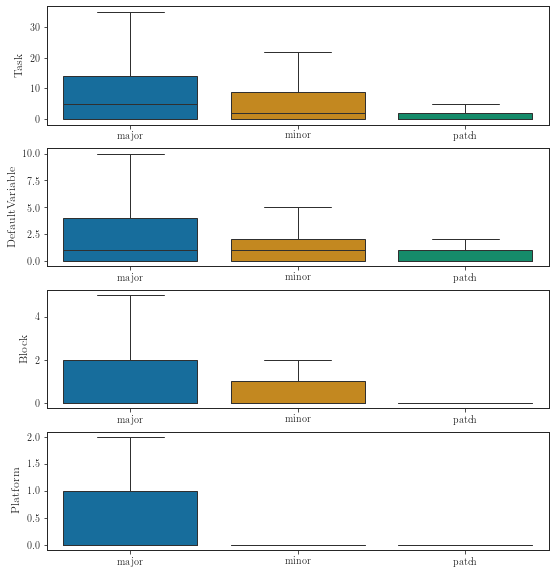

In [18]:
cols = ['Task','DefaultVariable','Block','Platform']
fig, axes = plt.subplots(len(cols), 1, sharex=False, sharey=False)
fig.set_size_inches(9,10)

for i, var in enumerate(cols):
    df_tmp = df_melted.query('variable =="'+var+'"')
    ax = sns.boxplot(x="release", 
                     y="value", 
                     order = ['major','minor','patch'],
                     data=df_tmp, 
                     ax=axes[i],
                     #color='blue',
                     showfliers=False,
                     linewidth=1)
    #ax.figure.set_size_inches(9,3)
    ax.set_ylabel(var)
    ax.set_xlabel('')
    #ax.set_xlabel('proportion of releases')
    #ax.set_xlim(0,40)


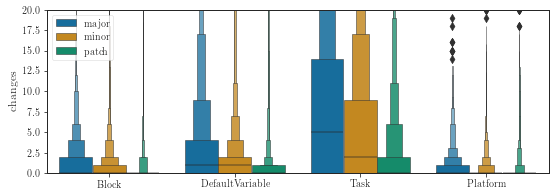

In [19]:
# Distribution of number of changes for each variable
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
fig.set_size_inches(9,3)
cols = ['Task','DefaultVariable','Block','Platform']

df_melted2 = df_melted[df_melted.variable.isin(cols)]
ax = sns.boxenplot(x="variable", 
                 y="value", 
                 hue='release',
                 hue_order = ['major','minor','patch'],
                 data=df_melted2, 
                #ax=axes[i],
                 #color='blue',
                 #showfliers=False,
                 linewidth=1)
#ax.figure.set_size_inches(9,3)
ax.set_ylabel('changes')
ax.set_xlabel('')
ax.set_ylim(0,20)
ax.legend(loc='upper left')


In [20]:
prop = diffs[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]

In [21]:
diffs.release.unique()

array(['patch', 'minor', 'major'], dtype=object)

## Let's check how many versions changes specific variables

In [22]:
cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']
tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
print(tab.sort_values('major', ascending=False)[['patch','minor','major']].to_latex())

\begin{tabular}{lrrr}
\toprule
release &  patch &  minor &  major \\
\midrule
Task                &  42.76 &  67.53 &  74.49 \\
DefaultVariable     &  26.25 &  52.46 &  63.85 \\
Block               &   9.06 &  27.45 &  38.59 \\
MetaEdit            &  12.16 &  20.42 &  37.50 \\
Platform            &   8.76 &  16.00 &  26.50 \\
RoleVariable        &  11.29 &  21.67 &  26.15 \\
TaskFile            &   4.98 &  17.56 &  24.23 \\
HandlerTask         &   3.47 &   9.71 &  14.41 \\
RoleVariableFile    &   4.13 &   9.58 &  11.62 \\
Dependency          &   1.27 &   2.82 &   6.99 \\
HandlerBlock        &   1.08 &   3.66 &   6.01 \\
HandlerFile         &   0.50 &   1.93 &   4.01 \\
DefaultVariableFile &   1.03 &   1.58 &   1.97 \\
\bottomrule
\end{tabular}



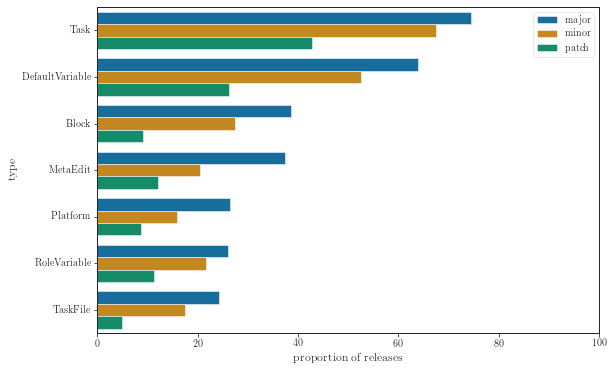

In [23]:
df_melted = pd.melt(tab.reset_index(), 
             id_vars=['index'],
             value_vars=['major','minor','patch']
            ).rename(columns={'index':'type'})
ax = sns.barplot(y="type", 
                 x="value", 
                 hue = 'release',
                 data=df_melted, 
                 hue_order = ['major','minor','patch'],
                 order = tab.sort_values('major', ascending=False).head(7).reset_index()['index'].tolist()
                )
ax.figure.set_size_inches(9,6)
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)
ax.legend(loc='upper right') #handles=legend_elements, 

In [24]:
# Considering all releases
prop = len(diffs[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop
    print(x, round(df_tmp, 2))

Block 14.73
RoleVariable 14.4
RoleVariableFile 5.75
DefaultVariable 34.11
DefaultVariableFile 1.2
Dependency 1.91
HandlerBlock 1.91
HandlerTask 5.44
HandlerFile 1.0
Task 50.0
TaskFile 8.82
Platform 11.3
MetaEdit 15.31


In [25]:
diffs_folders= diffs.copy()
diffs_folders['tasks'] = diffs_folders['Task'] + diffs_folders['Block'] + diffs_folders['TaskFile']
diffs_folders['defaults'] = diffs_folders['DefaultVariable'] + diffs_folders['DefaultVariableFile'] 
diffs_folders['meta'] = diffs_folders['MetaEdit'] + diffs_folders['Platform'] + diffs_folders['Dependency']
diffs_folders['vars'] = diffs_folders['RoleVariable'] + diffs_folders['RoleVariableFile'] 
diffs_folders['handlers'] = diffs_folders['HandlerTask'] + diffs_folders['HandlerBlock'] + diffs_folders['HandlerFile']
df_melted_2 = (pd.melt(diffs_folders.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )
prop_2 = diffs_folders[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]

cols = ['tasks','defaults','meta','vars','handlers']

tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs_folders.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop_2
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
print(tab.sort_values('major', ascending=False)[['patch','minor','major']].to_latex())

\begin{tabular}{lrrr}
\toprule
release &  patch &  minor &  major \\
\midrule
tasks    &  42.94 &  67.61 &  74.64 \\
defaults &  26.32 &  52.53 &  63.90 \\
meta     &  18.62 &  30.18 &  49.77 \\
vars     &  11.88 &  22.35 &  27.01 \\
handlers &   3.65 &  10.05 &  15.64 \\
\bottomrule
\end{tabular}



In [26]:
prop_2 = len(diffs_folders[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs_folders.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop_2
    print(x, round(df_tmp, 2))

tasks 50.16
defaults 34.18
meta 22.81
vars 15.02
handlers 5.71


In [27]:
prop = diffs[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
cols = ['DefaultVariableAddition','DefaultVariableEdit','DefaultVariableRelocation','DefaultVariableRemoval', 
 'TaskAddition','TaskEdit','TaskRelocation','TaskRemoval']
tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
tab

release,major,minor,patch
DefaultVariableAddition,42.18,37.97,13.12
DefaultVariableEdit,33.02,22.76,14.55
DefaultVariableRelocation,0.07,0.03,0.06
DefaultVariableRemoval,30.14,9.70,3.55
TaskAddition,44.89,40.90,15.66
TaskEdit,62.60,53.93,35.13
TaskRelocation,41.91,34.66,14.15
TaskRemoval,30.53,15.67,6.22


In [28]:
prop = len(diffs[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop
    print(x, round(df_tmp, 2))

DefaultVariableAddition 20.25
DefaultVariableEdit 17.35
DefaultVariableRelocation 0.06
DefaultVariableRemoval 6.27
TaskAddition 22.89
TaskEdit 40.8
TaskRelocation 20.22
TaskRemoval 9.59


In [29]:
print('Analysis for zero release')
diffs_zero = diffs.copy()
diffs_zero['zero'] =diffs_zero['v2'].apply(lambda x: x.startswith('0.'))
diffs_zero = diffs_zero.query('zero == True')
cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']
tab =[]
prop = diffs_zero[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs_zero.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
tab.sort_values('minor', ascending=False)

Analysis for zero release


release,minor,patch
Task,67.61,51.94
DefaultVariable,56.32,30.93
Block,31.11,13.72
MetaEdit,22.24,14.08
TaskFile,21.60,7.36
RoleVariable,19.85,8.18
Platform,14.71,6.12
HandlerTask,11.87,5.44
RoleVariableFile,10.27,2.43
HandlerBlock,4.91,1.80


In [30]:
def sum_row(d, cols):
    s = 0
    for c in cols:
        s = s + d[c]
    return s

In [31]:
cols = diffs.drop(['id','v1','v2', 'tot','fromm','release'], axis=1).columns.tolist()

diffs['total'] = diffs.fillna(0).apply(lambda d: sum_row(d, cols), axis=1)

In [32]:
diffs['total2'] = diffs['total'].apply(lambda d: d>0)


In [53]:
# Releases that did not touch anything
len(diffs.query('total==0'))*100/len(diffs)

25.929497351268218

In [ ]:
#len(diffs.query('total==0'))*100/prop, len(diffs.query('total>0'))*100/prop
